주석과 마크다운 병행하여 필요 설명 기술

# Step 1. 실험환경  Set-up

In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [143]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# *************************************************
# 노드에 있는 것과 다른 수치로 변경해서 3회 테스트
BATCH_SIZE = 16      # hyper-parameter 변경 값 16, 32, 8
EPOCHS = 25       # epochs 25, 20, 30

print(ROOT_PATH)

/aiffel/aiffel


# Step 2. 데이터 준비

In [144]:
# 데이터 개수 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print("train_count :", len(train_filenames))
print("test_count :", len(test_filenames))
print("val_count :", len(val_filenames))

train_count : 5216
test_count : 624
val_count : 16


In [145]:
# validation 개수가 빈약하므로 train에서 val 보완

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print("train_count :", len(train_filenames))
print("val_count :", len(val_filenames))

train_count : 4185
val_count : 1047


In [146]:
# train 데이터에 정상 이미지, 폐렴 이미지 개수 확인

# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0582-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person313_bacteria_1457.jpeg


In [147]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1071
Pneumonia images count in training set: 3114


우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

In [148]:
# tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해줌

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [149]:
# train, validation 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [150]:
# 파일 경로의 'NOMAL', 'PNEUMONIA' 를 이용해 라벨 데이터 생성

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # PNEUMONIA = 양성(True), NOMAL = 음성(False)

In [151]:
# 이미지 사이즈 통일 + 이미지 사이즈 줄이기(효율적인 GPU 메모리 사용을 위해)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [152]:
# train, validation dataset 생성

# num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해 줍니다.

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [153]:
# 리사이즈, 라벨 결과 확인

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [154]:
# test dataset 생성

test_list_ds = tf.data.Dataset.list_files(TEST_PATH) # df.data 파이프라인 사용으로 학습데이터 효율적 사용
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [155]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [138]:
#def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # shuffle() 고정크기 버퍼 유지, 무작위로 균일하게 다음 요소 선택
    ds = ds.repeat() # 여러 번 데이터셋을 사용할 수 있게 자동으로 맞춰줌 (100개 10번 반복 1000개 데이터 필요)
    ds = ds.batch(BATCH_SIZE) # BATCH_SIZE 만큼 배치로 주어짐 (100개 10개 배치 1개 배치 10개 데이터)
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 첫 번째 데이터 GPU 학습 동안 두 번째 데이터 CPU에서 준비 (리소스 유휴 상태 줄임)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

★★★★★ augmentation (부족한 데이터를 극복하는 방법)
- 좌우 반전, 회전 사용. 노이즈는 의료 영상에 부정적 효과를 주기 때문에 제외.

# Step 3. 데이터 시각화

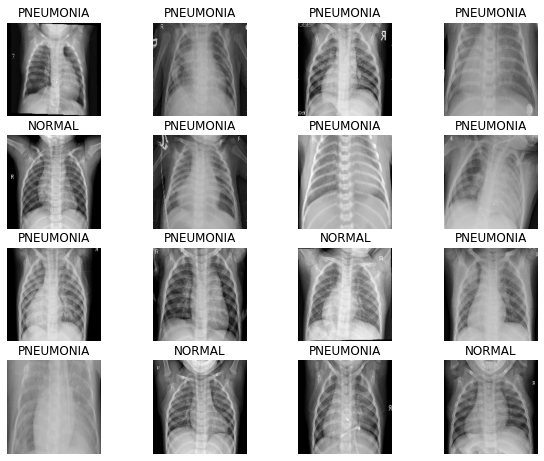

In [156]:
# train의 첫 번째 batch 추출
# 추출된 batch를 image, label로 나눔
# show_batch() 결과 사진 확인

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링

In [157]:
# Convolution block 생성

# conv_block : 
# Convolution 두 번 진행
# Batch Normalization을 통해 Gradient vanishing, Gradient Exploding 해결
# Max Pooling을 함

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [158]:
# Dense 블럭 생성

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

★★★★★ regularization (overfitting 방지)
- Batch Normalization
- Dropout
- ==> 두 가지를 함께 사용하는 것을 찬성, 반대하는 입장 공존
- 해당 테스트로 모델 성능 향상 여부 관찰

In [159]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),  #dropout test 0.2, 0.5, 0.3
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Step 5. 데이터 imbalance 처리

- imbalance : 한 라벨에 데이터가 몰려있는 경우를 뜻 함.
- ==> 학습 효과에 악영향 있을 수 있기에, 해결 필요

- Weight balancing 테크닉 사용하여 해결
- ==> training set 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법


In [160]:
# weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0   # weight_for_0은 'Normal' 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0  # weight_for_1은 'Pneumonia' 이미지에 사용할 weight

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# Step 6. 모델 훈련

In [161]:
# 위에서 만들었던 모델 함수인 build_model()을 model에 선언
# 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용
# optimizer로 'adam'을 사용
# 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [162]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 43s 135ms/step - loss: 0.4793 - accuracy: 0.7768 - precision: 0.9246 - recall: 0.7611 - val_loss: 0.6708 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 132ms/step - loss: 0.2933 - accuracy: 0.8835 - precision: 0.9695 - recall: 0.8718 - val_loss: 1.1209 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 35s 133ms/step - loss: 0.2383 - accuracy: 0.9030 - precision: 0.9779 - recall: 0.8920 - val_loss: 0.1432 - val_accuracy: 0.9587 - val_precision: 0.9775 - val_recall: 0.9660
Epoch 4/25
261/261 [==============================] - 35s 132ms/step - loss: 0.2230 - accuracy: 0.9110 - precision: 0.9713 - recall: 0.9071 - val_loss: 1.0592 - val_accuracy: 0.6260 - val_precision: 1.0000 - val_recall: 0.4922
Epoch 5/25
261/261 [==============================] - 34s 132ms/step - loss: 0.2106 - accura

# Step 7. 결과 확인과 시각화

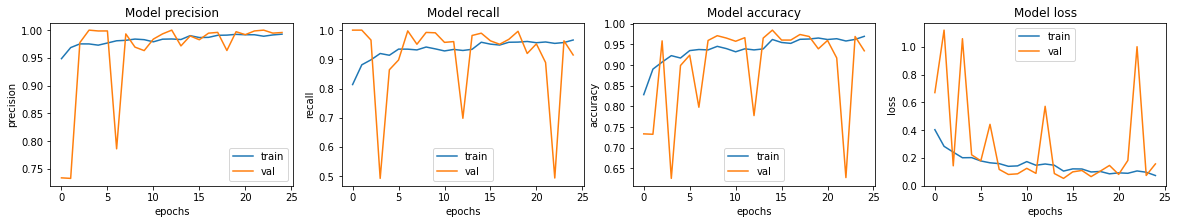

In [163]:
# 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [164]:
# 테스트 데이터로 모델 평가

# 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 0.5046 - accuracy: 0.8526 - precision: 0.8481 - recall: 0.9308
Loss: 0.5046159029006958,
Accuracy: 0.8525640964508057,
Precision: 0.8481308221817017,
Recall: 0.9307692050933838


- accuracy 우선 고려
- 의료 영상 모델의 특성상 recall도 중요

# 회고 : 실험 결과 기술

### Step 1에서 Batch size, Epoch 변경

참고자료 : https://blog.lunit.io/2018/08/03/batch-size-in-deep-learning/

- Batch size 16, Epoch 25
- Loss: 0.7322244644165039, Accuracy: 0.8461538553237915, Precision: 0.8114407062530518, Recall: 0.9820512533187866

- Batch size 32, Epoch 25
- Loss: 1.2270925045013428, Accuracy: 0.7996794581413269, Precision: 0.7644710540771484, Recall: 0.9820512533187866

- Batch size 32, Epoch 20
- Loss: 1.8497824668884277, Accuracy: 0.6410256624221802, Precision: 0.6351791620254517, Recall: 1.0

- Batch size 32, Epoch 30
- Loss: 0.9551029801368713, Accuracy: 0.8237179517745972, Precision: 0.7845528721809387, Recall: 0.9897435903549194

- Batch size 16, Epoch 20
- Loss: 0.9381200075149536, Accuracy: 0.7900640964508057, Precision: 0.7514563202857971, Recall: 0.9923076629638672

- Batch size 16, Epoch 30
- Loss: 1.1993666887283325, Accuracy: 0.8349359035491943, Precision: 0.7958762645721436, Recall: 0.9897435903549194

- Batch size 8, Epoch 25
- Loss: 0.7958132028579712, Accuracy: 0.7868589758872986, Precision: 0.7495145797729492, Recall: 0.9897435903549194

==> Batch size, Epoch 변경해도 accuracy 85% 넘을 수 없음

### Step 4에서 Dropout 변경

참고자료 : https://www.tensorflow.org/tutorials/keras/overfit_and_underfit?hl=ko#%EB%93%9C%EB%A1%AD%EC%95%84%EC%9B%83_%EC%B6%94%EA%B0%80%ED%95%98%EA%B8%B0

- Batch size 16, Epoch 25, Dropout 0.2 ==> Accuracy: 0.8461538553237915
- Batch size 16, Epoch 25, Dropout 0.5 ==> Accuracy: 0.6939102411270142
- Batch size 16, Epoch 25, Dropout 0.3 ==> Accuracy: 0.8205128312110901

==> Dropout 비중을 높일수록 정확도(Accuracy)가 낮아짐

### Step 4에서 Dropout 제거

- Accuracy: 0.7756410241127014 ==> 정확도 더 낮아짐, Dropout 0.2 반영해야 함

### Step 4에서 BatchNomalization 제거

- Batch size 16, Epoch 25, Dropout 0.2, Accuracy: 0.375 ==> 처참한 결과, BatchNomalization은 필수 적용해야 함

### Step 2에서 augmentation 좌우반전 도입

- Accuracy: 0.8525640964508057 ==> 핵심 원인은 부족한 데이터였다. augmentation으로 데이터의 종류와 양을 증가시켜주니 85%의 정확도 나옴